## BF Effect on Galaxy Shape w/ Galsim

Originally created by Alex Broughton


In [1]:
! eups list -s | grep lsst_distrib

eups                  LOCAL:/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2022_32/conda/envs/lsst-scipipe-4.1.0-ext/eups 	setup
lsst_distrib          g0b29ad24fb+cafeaf151e 	w_2022_32 current w_latest setup


In [2]:
# Helper functions
import sys
import os
import math
import logging
import galsim
import numpy as np
import matplotlib.pyplot as plt

def calc2ndMom(results):
    # Calculate Second Moments
    e1 = results.observed_shape.e1
    e2 = results.observed_shape.e2
    sigma = results.moments_sigma
    sigma_ave = sigma / (1 - e1**2 - e2**2 )**(0.25) 
    Ixx = (1+e1) * sigma_ave**2
    Iyy = (1-e1) * sigma_ave**2
    Ixy = e2 * (sigma_ave**2) 
    
    return Ixx, Iyy, Ixy

#### Galaxy @ 680nm, Flux 10^3 - 10^6

In [6]:
# model atmospheric turbulence as a VonKarman, with some small shear
#gprof = galsim.VonKarman(lam=1000.,r0=0.2,L0=10.0).shear(g1=0.06, g2=-0.05)

# add 4.5 microns sigma of Gaussian to model diffusion
# convert 4.5 microns to arcsec with factor 0.2"/10micron 
pixscale = 0.2/10.e-6
dprof = galsim.Gaussian(sigma=2.0e-6*pixscale)

# Airy function to simulate diffraction through mask
#lam_over_diam = 0.00000475*(680./450.)  # radians
#lam_over_diam *= 206265  # Convert to arcsec
#airy = galsim.Airy(lam_over_diam)

# Create a flat spectral energy density profile
sed = galsim.SED('wave**1.0',wave_type="nm", flux_type="1")

# Define the galaxy profile (returns instance of ChromaticObject)
chromatic_obj = galsim.Convolve([dprof]) * sed

# Select a single wavelength in nm (returns instance of GSObject)
prof = chromatic_obj.evaluateAtWavelength(450.0).shear(g1=0.2, g2=0.05).withFlux(305180*.91893*1.08*.93*1.08*1.006*.95 * (5+1)*(1/1.25))

# add BF effect
sensor = galsim.SiliconSensor(strength = 1., diffusion_factor=1., nrecalc=1000)

# draw image
blank_image = galsim.Image(65,65,scale=0.2,xmin=0,ymin=0,dtype=np.float64)  
image = prof.drawImage(image=blank_image, scale=0.2, method="phot", save_photons=True)

# calculate HSM moments (these are in pixel coordinates)
new_params = galsim.hsm.HSMParams(max_amoment=5.0e5)
results = image.FindAdaptiveMom(hsmparams=new_params)
Ixx, Iyy, Ixy = calc2ndMom(results)
flux = results.moments_amp


    

# plot it
plt.figure(figsize=(8,6))
plt.imshow(image.array)

GalSimHSMError: Error: too many iterations in adaptive moments


### With BF

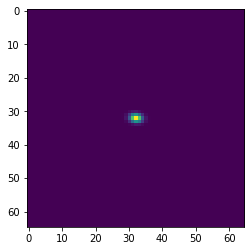

In [5]:
import sys
import os
import math
import logging
import galsim

"""
About as simple as it gets:
  - Use a circular Gaussian profile for the galaxy.
  - Convolve it by a circular Gaussian PSF.
  - Add Gaussian noise to the image.
"""

gal_flux = 2.0e4    # total counts on the image
gal_sigma = 0.2     # arcsec
pixel_scale = 0.2  # arcsec / pixel
noise = 10.        # standard deviation of the counts in each pixel

# add BF effect
sensor = galsim.SiliconSensor(strength = 1., diffusion_factor=1., nrecalc=10000)

# Create a flat spectral energy density profile
sed = galsim.SED('wave**1.0',wave_type="nm", flux_type="1")

# Define the galaxy profile
gal = galsim.Gaussian(flux=gal_flux, sigma=gal_sigma) * sed
final = gal.shear(g1=0.2, g2=0.05).evaluateAtWavelength(680.0)


# Draw the image with a particular pixel scale, given in arcsec/pixel.
# The returned image has a member, added_flux, which is gives the total flux actually added to
# the image.  One could use this value to check if the image is large enough for some desired
# accuracy level.  Here, we just ignore it.

blank_image = galsim.Image(65,65,scale=0.2,xmin=0,ymin=0,dtype=np.float64)  
image1 = final.drawImage(image=blank_image, scale=0.2, method="phot", save_photons=True)


# Add Gaussian noise to the image with specified sigma
# image.addNoise(galsim.GaussianNoise(sigma=noise))

# calculate HSM moments (these are in pixel coordinates)
results = image1.FindAdaptiveMom()
Ixx, Iyy, Ixy = calc2ndMom(results)
flux = results.moments_amp

# Calculate higher order image moments
sys.path.append('/sdf/home/a/abrought/bin/PSFHOME/psfhome')
from moments import *
psf_base = galsim.Gaussian(sigma = 1.0)
sxm = shapeletXmoment(psf_base, 6)
pqlist = sxm.get_pq_full(6)
moments = sxm.get_all_moments(image1, pqlist)


plt.imshow(image1.array)

In [42]:
print(Ixx, Iyy, Ixy)
def get_pq_full(nmax):
    pq_list = []
        
    for n in range(2, nmax+1):
        p = 0
        q = n

        pq_list.append((p,q))

        while p<n:
            p+=1
            q-=1
            pq_list.append((p,q))
            
    return pq_list

from IPython.display import display, Latex
for i, (p,q) in enumerate(get_pq_full(6)):
    display(Latex(r'$M_{%s%s} = %s$' % (p, q,moments[i])))


HOMs[0] = moments
print(moments.shape)
print(moments.shape)

1.58951906944595 0.7283978421357884 0.10001441962735357


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

(25,)
(25,)


### Without BF

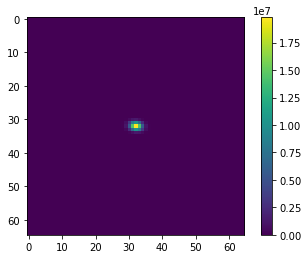

In [11]:
import sys
import os
import math
import logging
import galsim

"""
About as simple as it gets:
  - Use a circular Gaussian profile for the galaxy.
  - Convolve it by a circular Gaussian PSF.
  - Add Gaussian noise to the image.
"""

gal_flux = 2.e5    # total counts on the image
gal_sigma = 0.2     # arcsec
pixel_scale = 0.2  # arcsec / pixel
noise = 10.        # standard deviation of the counts in each pixel

# add BF effect
sensor = galsim.SiliconSensor(strength = 0.0001, diffusion_factor=1., nrecalc=10000)

# Create a flat spectral energy density profile
sed = galsim.SED('wave**1.0',wave_type="nm", flux_type="1")

# Define the galaxy profile
gal = galsim.Gaussian(flux=gal_flux, sigma=gal_sigma) * sed
final = gal.shear(g1=0.2, g2=0.05).evaluateAtWavelength(680.0)


# Draw the image with a particular pixel scale, given in arcsec/pixel.
# The returned image has a member, added_flux, which is gives the total flux actually added to
# the image.  One could use this value to check if the image is large enough for some desired
# accuracy level.  Here, we just ignore it.

blank_image = galsim.Image(65,65,scale=0.2,xmin=0,ymin=0,dtype=np.float64)  
image2 = final.drawImage(image=blank_image, scale=0.2, method="phot", save_photons=True)


# Add Gaussian noise to the image with specified sigma
# image.addNoise(galsim.GaussianNoise(sigma=noise))

# calculate HSM moments (these are in pixel coordinates)
results = image2.FindAdaptiveMom()
Ixx, Iyy, Ixy = calc2ndMom(results)
flux = results.moments_amp

plt.imshow(image2.array)
plt.colorbar()

In [7]:
print(Ixx, Iyy, Ixy)

1.5912072863297602 0.7288545654252787 0.1006859930808992


/tmp/ipykernel_75059/727903430.py:2: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow((image1.array-image2.array)/image2.array)


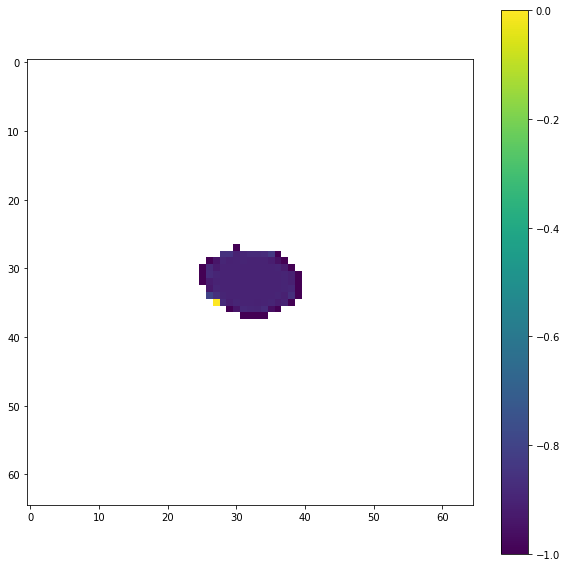

In [12]:
plt.figure(figsize=(10,10))
plt.imshow((image1.array-image2.array)/image2.array)
plt.colorbar()